In [0]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as img
from os import listdir

from keras import Model
from keras.layers import *
from keras.optimizers import SGD
from keras.metrics import binary_crossentropy, binary_accuracy
from google.colab import drive 
drive.mount('/content/drive')


In [0]:

dropout = .5
epochs = 100
batch_size = 128
seed = 1234
#benign_train_dir = '/content/drive/My Drive/data.zip (Unzipped Files)/train/benign/'
benign_train_dir = '/content/drive/My Drive/data.zip (Unzipped Files)/train/benign/'
malign_train_dir = '/content/drive/My Drive/data.zip (Unzipped Files)/train/malignant/'
benign_val_dir = '/content/drive/My Drive/data.zip (Unzipped Files)/test/benign/'
malign_val_dir = '/content/drive/My Drive/data.zip (Unzipped Files)/test/malignant/'
train_steps = (len(listdir(benign_train_dir))+len(listdir(malign_train_dir)))//batch_size
val_steps = len(listdir(benign_val_dir))+len(listdir(malign_val_dir))
np.random.seed(seed)

In [0]:

def lrGenerator(min_lr, max_lr, step):
    flag = False
    lr = max_lr
    
    while True:
        lr = lr+step if flag else lr-step
        flag = False if lr >= max_lr else True if lr <= min_lr else flag
        
        yield lr

In [0]:
pwd

'/content'

[Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/abs/1506.01186)

In [0]:
def trainDataGenerator():
    global alpha, train_steps, batch_size, benign_train_dir, malign_train_dir
    files = [benign_train_dir+f for f in listdir(benign_train_dir)]+\
            [malign_train_dir+f for f in listdir(malign_train_dir)]
    np.random.shuffle(files)
    
    for i in range(train_steps):
        result = [[], []]
        
        for f in files[i*batch_size:(i+1)*batch_size]:
            image = img.open(f)
            image = np.array(image).astype('float32')
            
            if np.random.choice([True, False]): # 50% chance of flipping the image horizontally.
                image = image[:, ::-1]
            if np.random.choice([True, False]): # 50% chance of flipping the image vertically.
                image = image[::-1, :]
            
            image = image/127.5-1 # Map values between -1 and 1.
            result[0].append(image)
            result[1].append(np.array([0]) if 'benign' in f else np.array([1]))
        
        result[0] = np.array(result[0])
        result[1] = np.array(result[1])
        yield result
        
def valDataGenerator():
    global benign_val_dir, malign_val_dir
    
    for f in listdir(benign_val_dir):
        result = [[], []]
        image = img.open(benign_val_dir+f)
        image = np.array(image).astype('float32')/127.5-1
        
        result[0].append(image)
        result[1].append(np.array([0]))
        
        result[0] = np.array(result[0])
        result[1] = np.array(result[1])
        yield result
    
    for f in listdir(malign_val_dir):
        result = [[], []]
        image = img.open(malign_val_dir+f)
        image = np.array(image).astype('float32')/127.5-1
        
        result[0].append(image)
        result[1].append(np.array([1]))
        
        result[0] = np.array(result[0])
        result[1] = np.array(result[1])
        yield result

In [0]:
class VariableDropout(Layer):
    def __init__(self, rate, noise_shape=None, seed=None, **kwargs):
        self.rate = K.variable(min(1., max(0., rate)))
        self.noise_shape = noise_shape
        self.seed = seed
        super(VariableDropout, self).__init__(**kwargs)

    def call(self, x, training=None):
        def dropout():
            return K.dropout(x,
                             self.rate,
                             self._get_noise_shape(x),
                             seed=self.seed)
            
        return K.in_train_phase(dropout, x,
                                training=training)
    
    def compute_output_shape(self, input_shape):
        return input_shape
        
    def set_rate(self, rate):
        K.set_value(self.rate, min(1, max(0., rate)))
        
    def _get_noise_shape(self, inputs):
        if self.noise_shape is None:
            return self.noise_shape

        symbolic_shape = K.shape(inputs)
        noise_shape = [symbolic_shape[axis] if shape is None else shape
                       for axis, shape in enumerate(self.noise_shape)]
        
        return tuple(noise_shape)

In [0]:
from keras import backend as K
lr = lrGenerator(.005, .025, .005)

def model():
    x = Input((224, 224, 3))
    y = Conv2D(16, 3, activation='relu')(x)
    y = MaxPool2D()(y)
    y = BatchNormalization()(y)
    y = Conv2D(32, 3, activation='relu')(y)
    y = MaxPool2D()(y)
    y = BatchNormalization()(y)
    y = Conv2D(64, 3, activation='relu')(y)
    y = MaxPool2D()(y)
    y = BatchNormalization()(y)
    y = Conv2D(128, 3, activation='relu')(y)
    y = MaxPool2D()(y)
    y = BatchNormalization()(y)
    y = Conv2D(256, 3, activation='relu')(y)
    y = MaxPool2D()(y)
    y = BatchNormalization()(y)
    y = Conv2D(512, 3, activation='relu')(y)
    y = GlobalAvgPool2D()(y)
    y = Dense(512, activation='relu')(y)
    y = VariableDropout(dropout, seed=seed, name='dropout')(y)
    y = Dense(1)(y)
    
    return Model(x, y)

def binaryCrossentropy(y_true, y_pred):
    return binary_crossentropy(y_true, K.sigmoid(y_pred))
def binaryAccuracy(y_true, y_pred):
    return binary_accuracy(y_true, K.sigmoid(y_pred))

model = model()
model.compile(SGD(next(lr), .9, nesterov=True), binaryCrossentropy, metrics=[binaryAccuracy])
model.summary()

tracking <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.5> rate
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 111, 111, 16)      0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 111, 111, 16)      64        
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 54, 54, 32)        0         
__________________________________________________

In [0]:
best_acc = 0.
train_loss = []
train_acc = []
val_loss = []
val_acc = []
for e in range(epochs):
    history = model.fit_generator(trainDataGenerator(),
                                  steps_per_epoch = train_steps,
                                  validation_data = valDataGenerator(),
                                  validation_steps = val_steps).history
    
    if history['val_binaryAccuracy'][0] > best_acc:
        best_acc = history['val_binaryAccuracy'][0]
        model.save('Model.h5')
        
    train_loss.append(history['loss'][0])
    train_acc.append(history['binaryAccuracy'][0])
    val_loss.append(history['val_loss'][0])
    val_acc.append(history['val_binaryAccuracy'][0])
    
    dropout *= .95
    model.get_layer('dropout').set_rate(dropout)
    K.set_value(model.optimizer.lr, next(lr))

Epoch 1/1
20/20 [==============================] - 410s 21s/step - loss: 0.4095 - binaryAccuracy: 0.8055 - val_loss: 1.2491 - val_binaryAccuracy: 0.5455
Epoch 1/1
20/20 [==============================] - 18s 895ms/step - loss: 0.3359 - binaryAccuracy: 0.8477 - val_loss: 1.7767 - val_binaryAccuracy: 0.5455
Epoch 1/1
20/20 [==============================] - 17s 832ms/step - loss: 0.3132 - binaryAccuracy: 0.8555 - val_loss: 2.2349 - val_binaryAccuracy: 0.5455
Epoch 1/1
20/20 [==============================] - 17s 832ms/step - loss: 0.2933 - binaryAccuracy: 0.8629 - val_loss: 2.6083 - val_binaryAccuracy: 0.5455
Epoch 1/1
20/20 [==============================] - 17s 832ms/step - loss: 0.2823 - binaryAccuracy: 0.8707 - val_loss: 3.0605 - val_binaryAccuracy: 0.5455
Epoch 1/1
20/20 [==============================] - 18s 898ms/step - loss: 0.2905 - binaryAccuracy: 0.8668 - val_loss: 3.1588 - val_binaryAccuracy: 0.5455
Epoch 1/1
20/20 [==============================] - 17s 834ms/step - loss: 0.2

Best accuracy: 88.94%


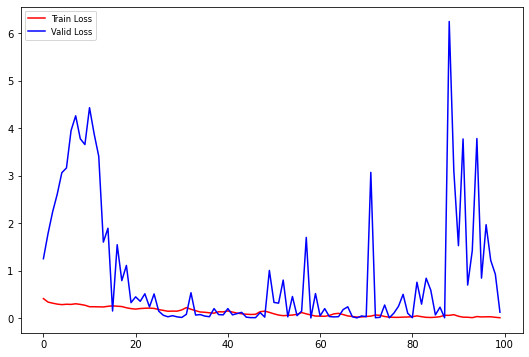

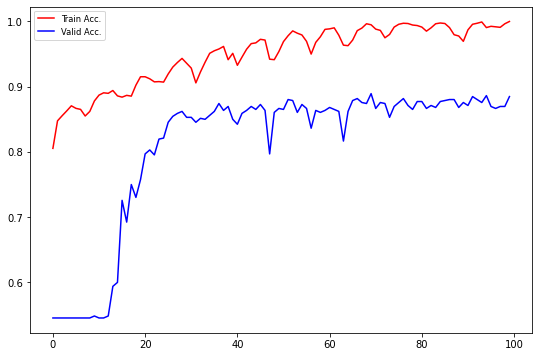

In [0]:
print('Best accuracy: {}%'.format(round(best_acc*100, 2)))

plt.figure(figsize=(9, 6))
plt.plot(train_loss, 'r-', label='Train Loss')
plt.plot(val_loss, 'b-', label='Valid Loss')
plt.legend(fontsize='small')
plt.show()

plt.figure(figsize=(9, 6))
plt.plot(train_acc, 'r-', label='Train Acc.')
plt.plot(val_acc, 'b-', label='Valid Acc.')
plt.legend(fontsize='small')
plt.show()